# Table of Contents

* Summary
* Load Libraries and Dataset
* Exploratory Data Analysis
* Data Preparation
* Modelling
* Kaggle Submission
* Results


---

# Summary
In this Kaggle competition the Santander Bank wants to predict "*which customers will make a specific transaction in the future, irrespective of the amount of money transacted.*" [ [Link to the competition](https://www.kaggle.com/c/santander-customer-transaction-prediction) ]

The best score in Kaggle is 0.92573 (as of 27 July 2020), and I achieved a score of 0.80469. 

It seems the data has been duplicated with "fake" observations and in order to get a score over 0.90 a "magic" feature needs to be created (e.g. see [this notebook](https://www.kaggle.com/cdeotte/200-magical-models-santander-0-920)). My focus in this notebook is not to find this "magic" feature, but to go through the data science process. Nonetheless, I did some experiments and it was an interesting learning experience, and perhaps something to explore further in the future. 

Let's start.


# Load libraries and dataset

## Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset

In [4]:
### Importing dataset from Kaggle
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

# Changing the working directory
### REMEMBER TO MOUNT GOOGLE DRIVE IF USING COLAB
%cd /content/drive/My Drive/Kaggle

# Run this once only to download the data directly from Kaggle
#!kaggle competitions download -c santander-customer-transaction-predic

/content/drive/My Drive/Kaggle


In [5]:
# Read original data
raw = pd.read_csv("train.csv.zip", compression='zip')

In [6]:
# Create a copy for manipulation
df = raw.copy()
df.drop("ID_code", axis=1, inplace=True) # Irrelevant column

# Exploratory Data Analysis

## Basic dataset insights

In [7]:
df.head()

target    var_0   var_1    var_2  ...  var_196  var_197  var_198  var_199
0       0   8.9255 -6.7863  11.9081  ...   7.8784   8.5635  12.7803  -1.0914
1       0  11.5006 -4.1473  13.8588  ...   8.1267   8.7889  18.3560   1.9518
2       0   8.6093 -2.7457  12.0805  ...  -6.5213   8.2675  14.7222   0.3965
3       0  11.0604 -2.1518   8.9522  ...  -2.9275  10.2922  17.9697  -8.9996
4       0   9.8369 -1.4834  12.8746  ...   3.9267   9.5031  17.9974  -8.8104

[5 rows x 201 columns]

In [ ]:
print("The shape of the dataframe is: {:,} columns and {:,} rows".format(df.shape[1], df.shape[0]))

The shape of the dataframe is: 201 columns and 200,000 rows


In [ ]:
df.dtypes.value_counts()

float64    200
int64        1
dtype: int64

In [ ]:
# Is the target the only int64?
df["target"].dtype

dtype('int64')

In [ ]:
# Checking NULL
null_count = sum(df.isnull().any())

print("There are {} NULL values in the dataframe".format(null_count))

There are 0 NULL values in the dataframe


In [ ]:
# Seems there aren't NULL values so that's good, no need to deal with it

In [ ]:
# Check basic statistics, although difficult to go into detail with so many columns
df.describe()

target          var_0  ...        var_198        var_199
count  200000.000000  200000.000000  ...  200000.000000  200000.000000
mean        0.100490      10.679914  ...      15.870720      -3.326537
std         0.300653       3.040051  ...       3.010945      10.438015
min         0.000000       0.408400  ...       6.299300     -38.852800
25%         0.000000       8.453850  ...      13.829700     -11.208475
50%         0.000000      10.524750  ...      15.934050      -2.819550
75%         0.000000      12.758200  ...      18.064725       4.836800
max         1.000000      20.315000  ...      26.079100      28.500700

[8 rows x 201 columns]

In [ ]:
# What's the range of all variables?
df_min = min(df.drop("target", axis=1).min()) # It first calculates the min by column, and then the min of all min. Same with max.
df_max = max(df.drop("target", axis=1).max())

print("The min value in the dataframe is: {}".format(df_min))
print("The max value in the dataframe is: {}".format(df_max))

The min value in the dataframe is: -90.2525
The max value in the dataframe is: 74.0321


In [ ]:
# Focusing on the target variable
obs_total = df.shape[0]
obs_0 = df["target"].value_counts()[0]
obs_1 = df["target"].value_counts()[1]

pct_0 = round(obs_0/obs_total,4)*100
pct_1 = round(obs_1/obs_total, 4)*100

print("There are {:,} observations with target value 0, and {:,} with target value 1".format(obs_0, obs_1))
print("Target 0 represents {}% of the total, while target 1 represents {}%".format(pct_0, pct_1))


There are 179,902 observations with target value 0, and 20,098 with target value 1
Target 0 represents 89.95% of the total, while target 1 represents 10.05%


In [ ]:
# Clearly an imbalanced dataset, an over/under-sampling strategy will be needed.

## Graphics

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/boxplot.py:375: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


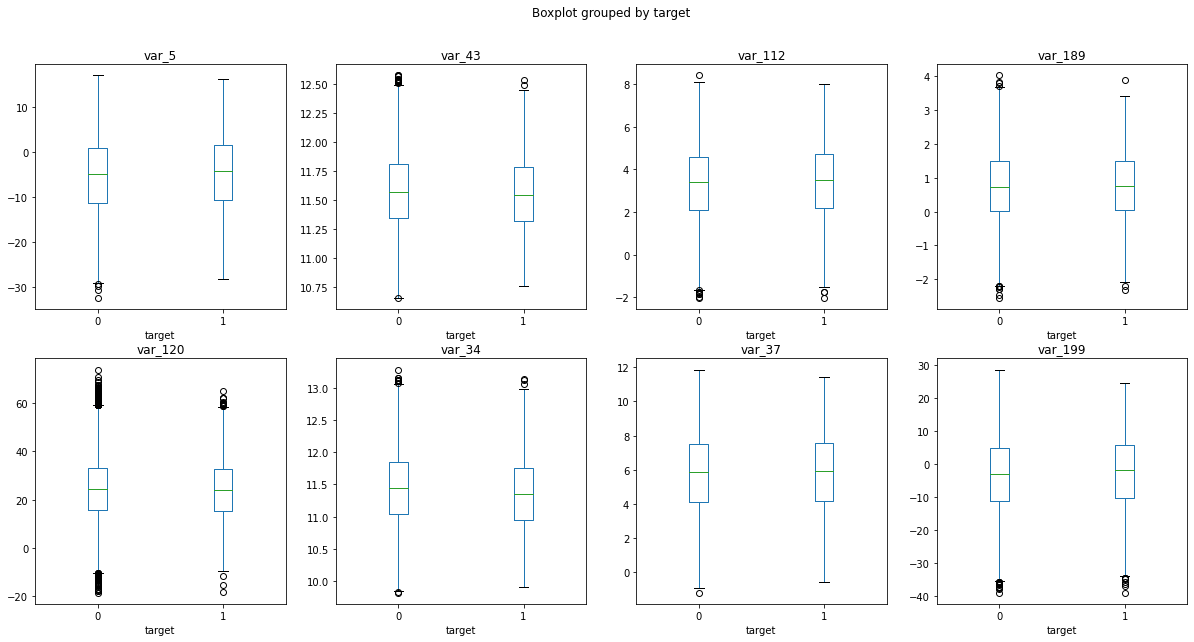

In [ ]:
# Some random boxplot against the target

fig, ax = plt.subplots(2,4,figsize=(20,10), sharey=False);
df.boxplot(["var_5", "var_43", "var_112", "var_189", "var_120", "var_34", "var_37", "var_199"], by="target", grid=False, ax=ax);

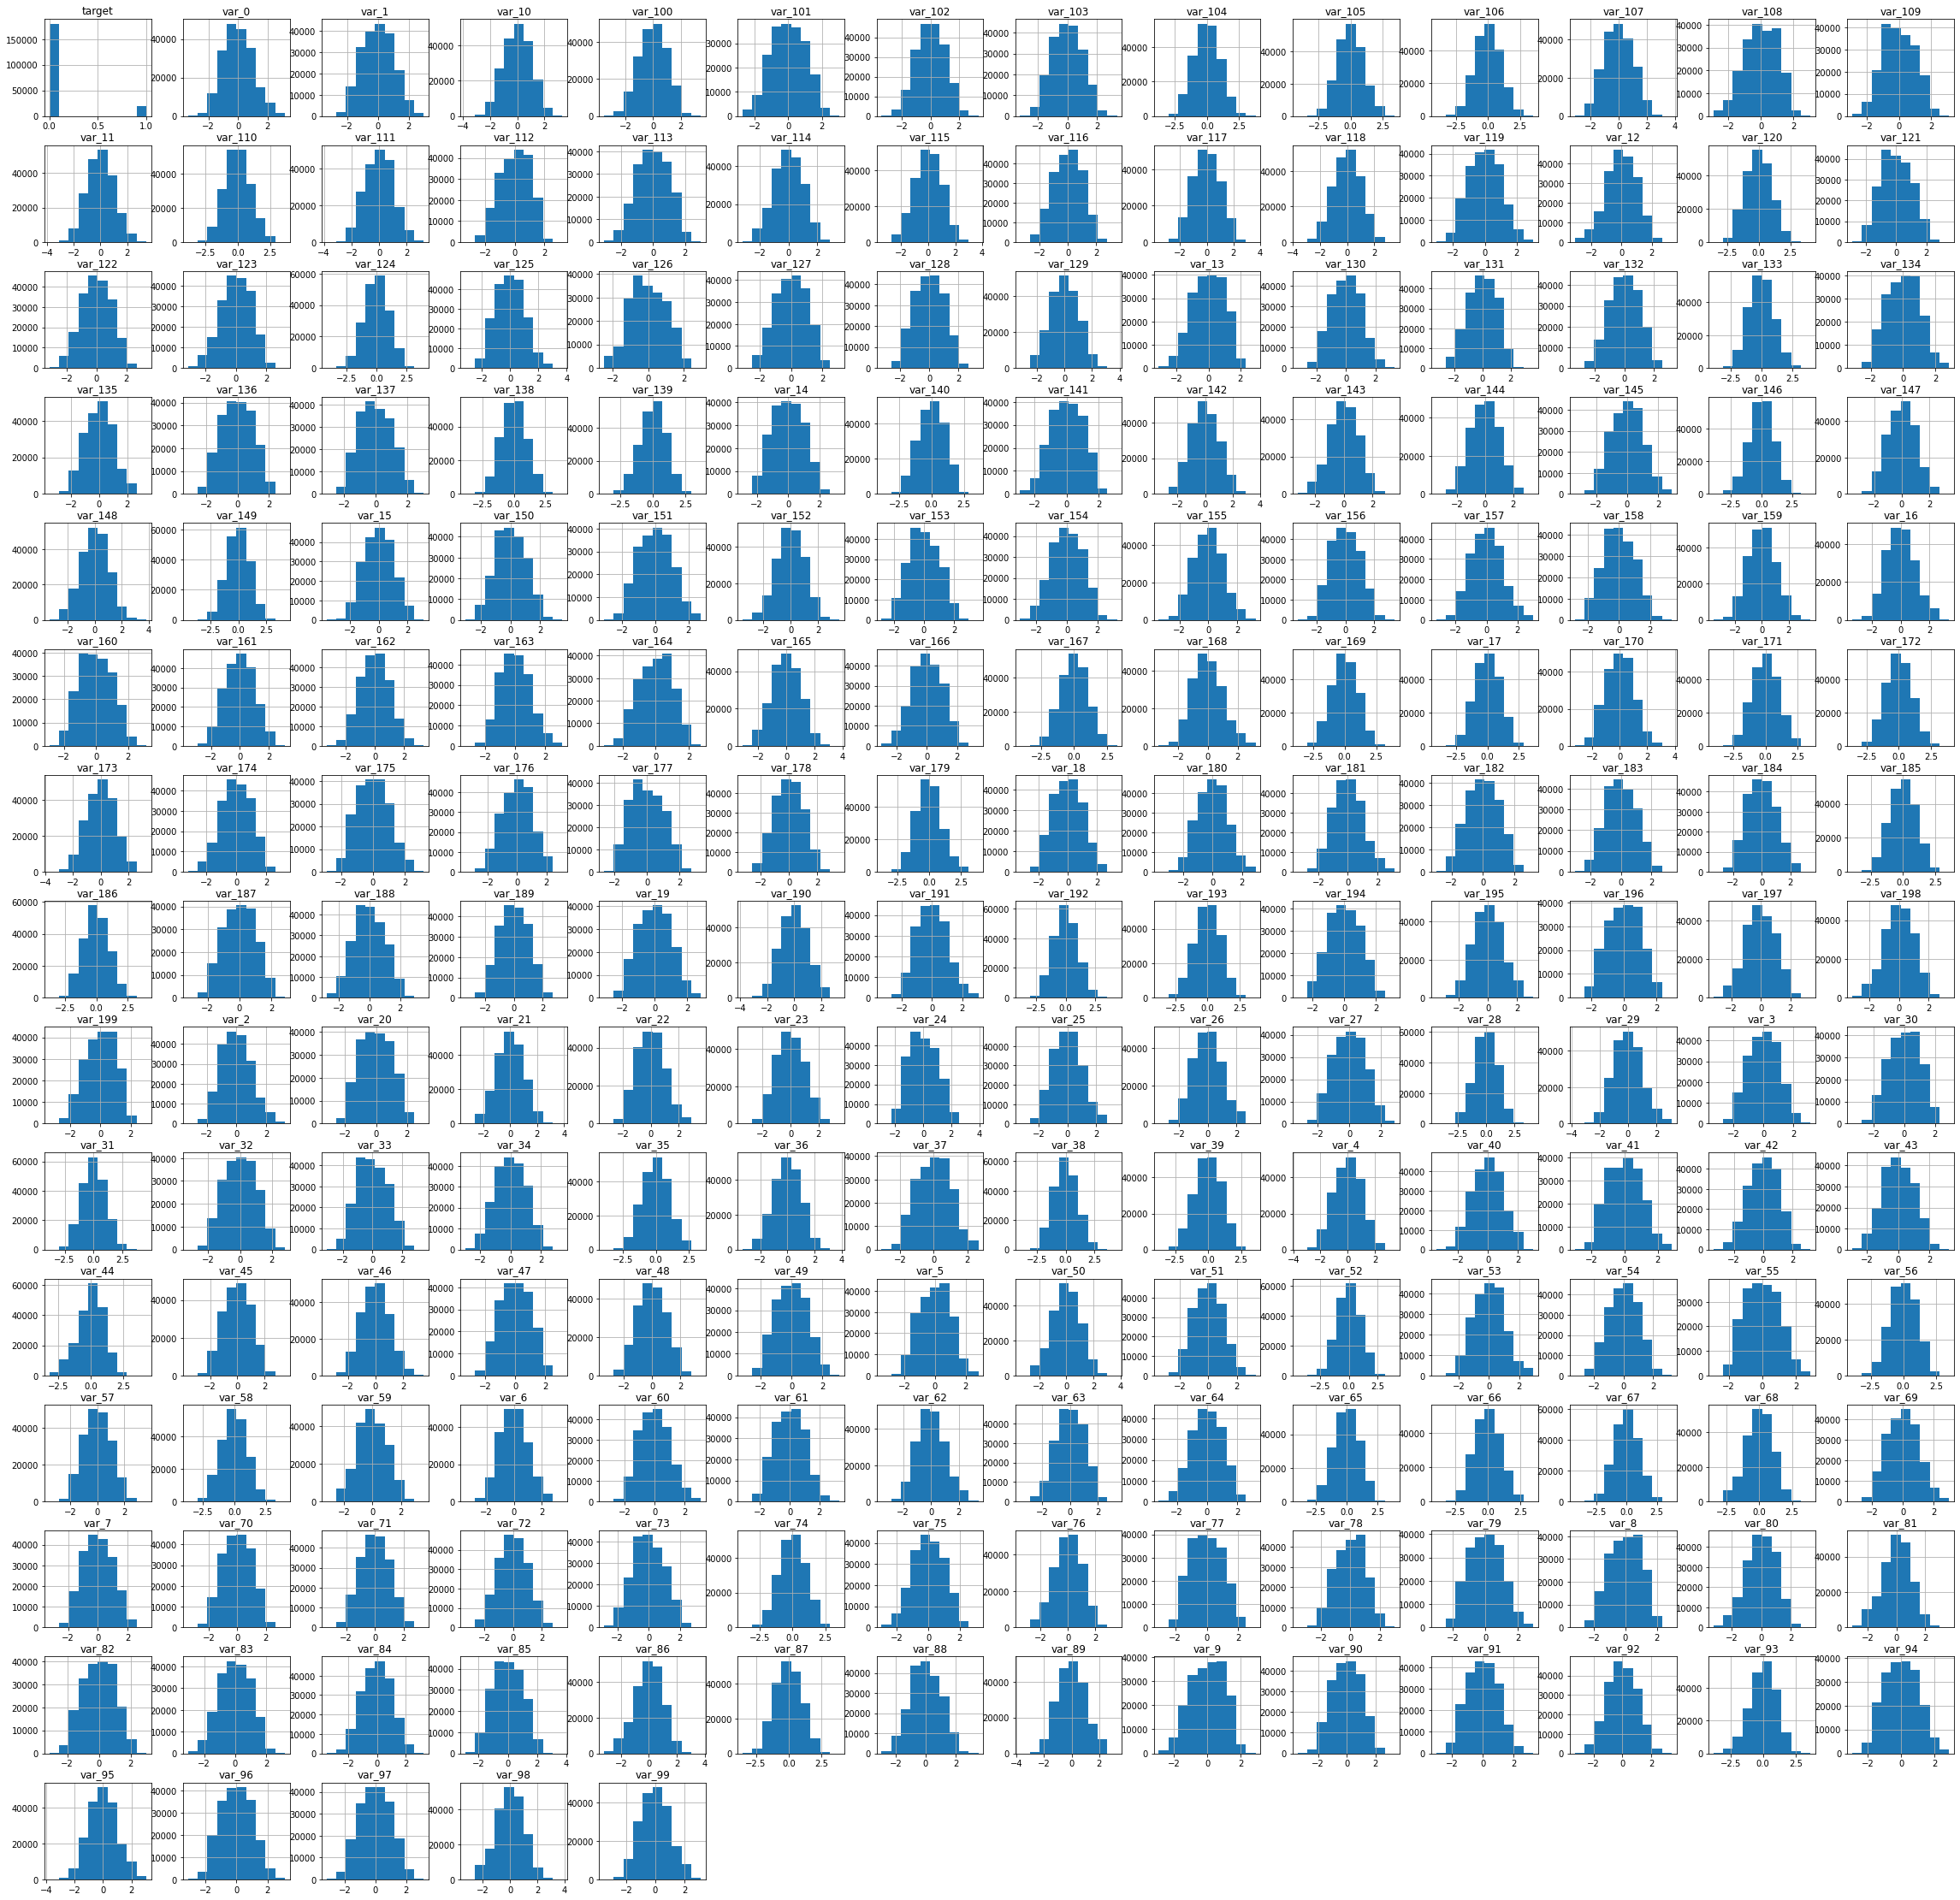

In [ ]:
# How's the data distributed?
df.hist(figsize=(40,40));

## Correlations

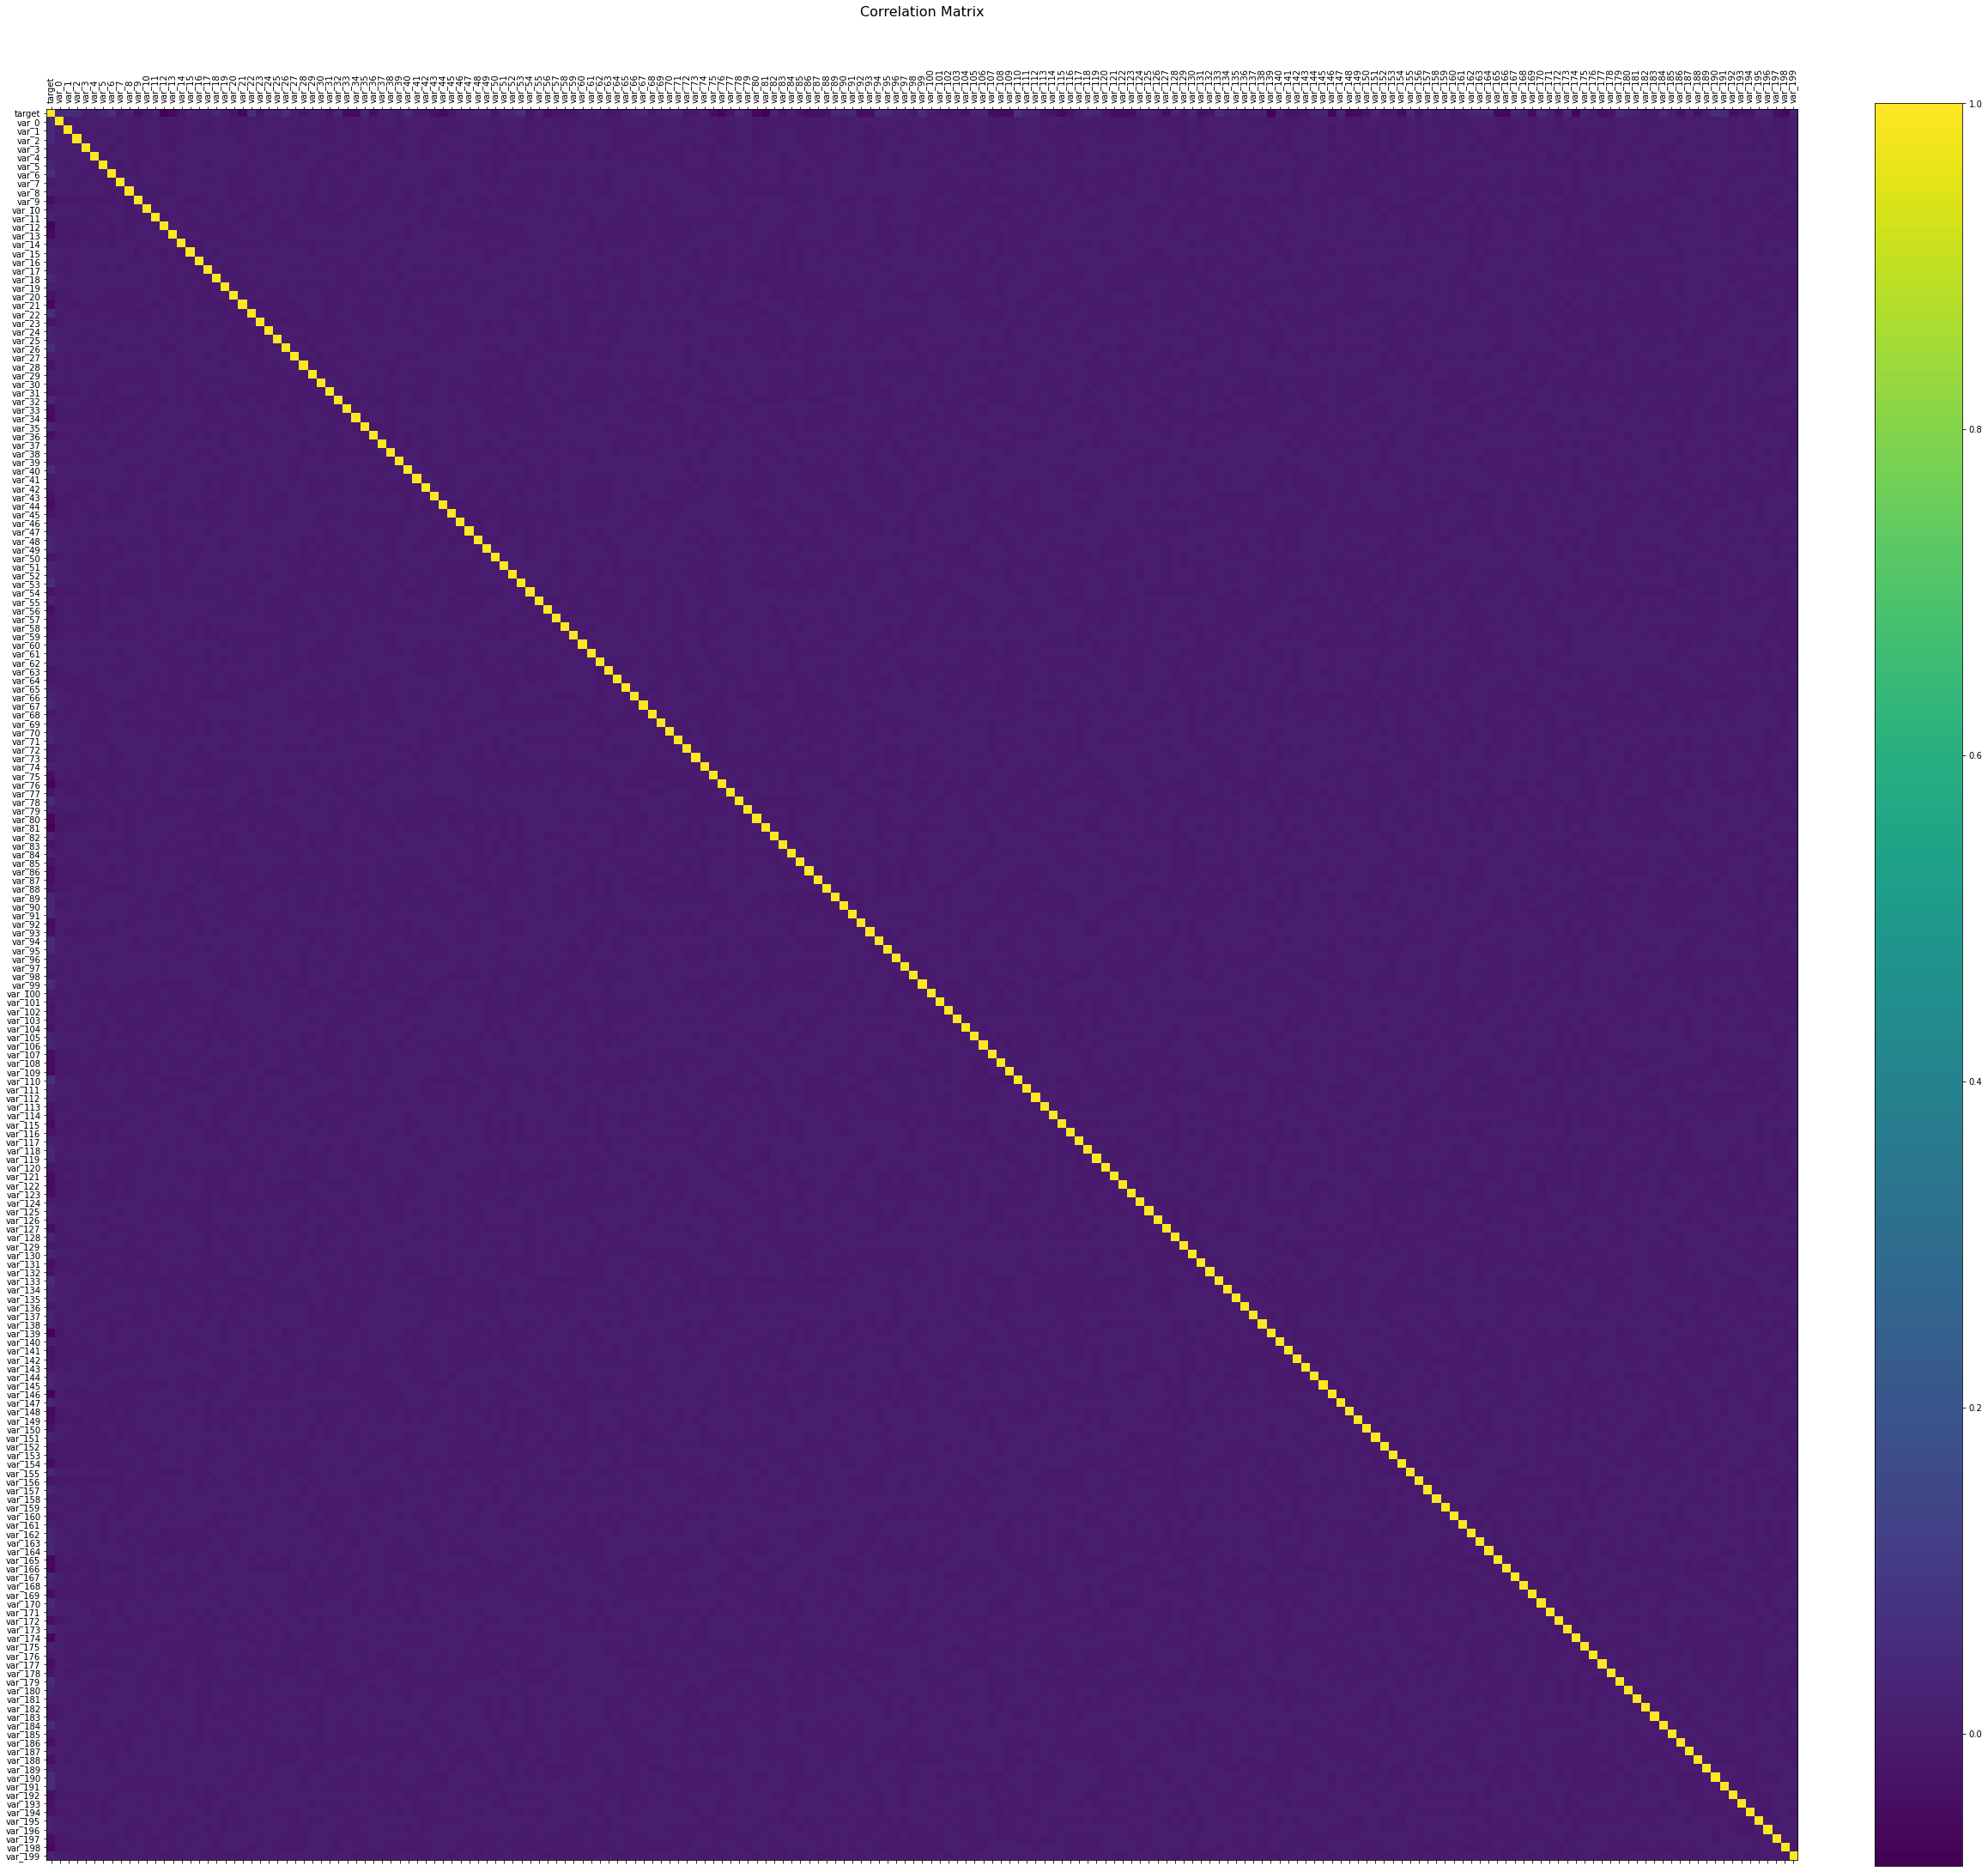

In [8]:
# Source: https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas
f = plt.figure(figsize=(40, 40))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, rotation=90)
plt.yticks(range(df.shape[1]), df.columns)
plt.colorbar(fraction=0.046, pad = 0.04)
plt.title('Correlation Matrix', fontsize=16);

### Target

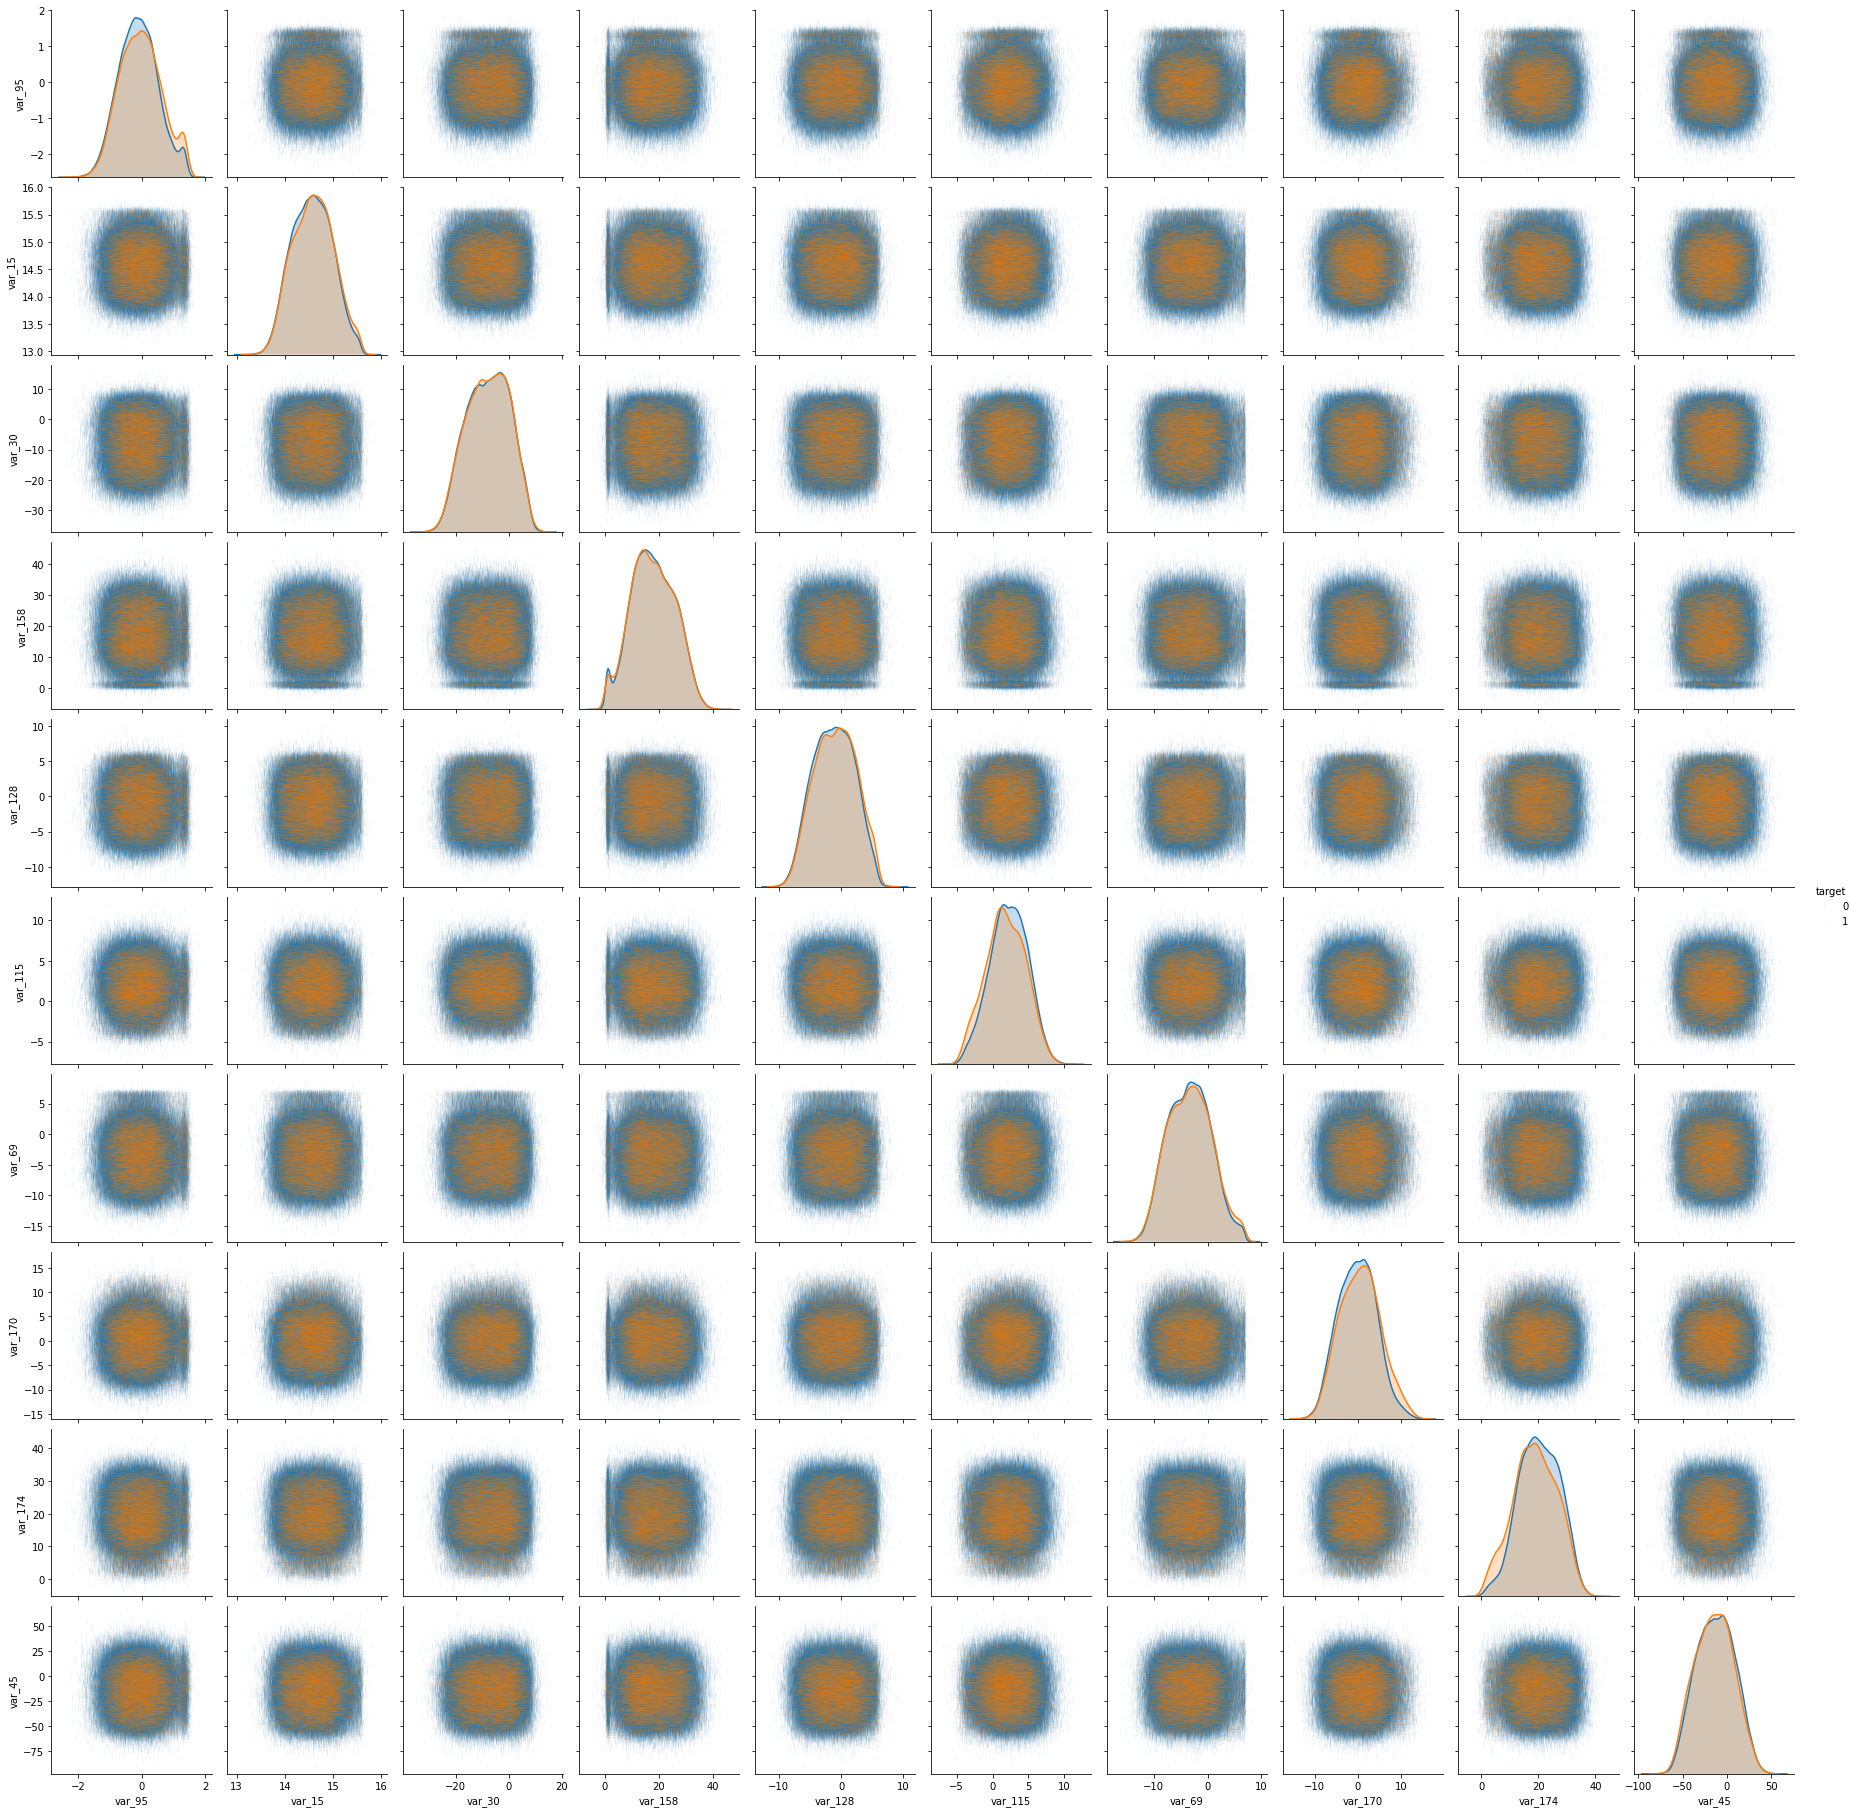

In [22]:
# Plotting the correlation of 10 random features

random_columns = df.drop("target", axis=1).sample(10, axis=1, random_state=42).columns.to_list()
sns.pairplot(df, vars=random_columns, hue="target", plot_kws={'alpha':0.05}, markers=['|','_']); # 0 is blue and 1 is orange

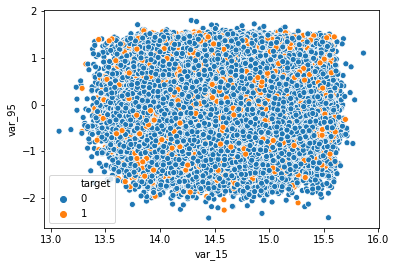

In [24]:
# Looking at the previous plot it seems that when the target is 1 it's concentrated in the middle of the data, however having a closer look shows a more random picture
sns.scatterplot("var_15", "var_95", hue="target", data = df);

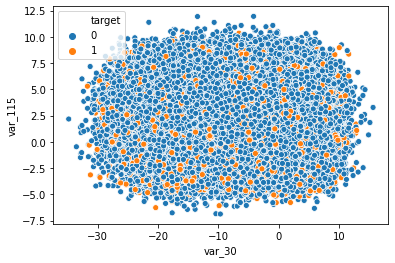

In [25]:
sns.scatterplot("var_30", "var_115", hue="target", data = df);

# Data Preparation

## Outliers

In [26]:
def identify_outliers(df):

  idx = []

  for col in df.columns:
    if not col == "target":
      std = df[col].std() 
      threshold = std * 3 
      idx_col = df[col][(df[col]>=abs(threshold)) | (df[col]<=-abs(threshold))].index.to_list()
      idx.append(idx_col)
  
  idx_flat = list(set([i for j in idx for i in j]))

  return idx_flat

In [27]:
outliers_idx = identify_outliers(df)
len(outliers_idx)

200000

In [ ]:
# Can't use this method for now, since it's removing all dataset
#df1 = df.drop(df.index[outliers_idx])

In [ ]:
#df.shape[0] - df1.shape[0] == len(outliers_idx) # Just a quick check

True

## Standardise

In [52]:
# Standardise the data for modelling
sc = StandardScaler()
df_sc = pd.DataFrame(sc.fit_transform(df.drop("target", axis=1)))
df_sc.columns = df.drop("target", axis=1).columns
df_sc["target"] = df["target"].copy()


## Downsampling
Since there are over 20K observations with the minority class I'll use the downsampling strategy.

In [55]:
df_0_downsampled = df_sc[df_sc["target"]==0].sample(len(df_sc[df_sc["target"]==1]), random_state=42)
df_1 = df_sc[df_sc["target"]==1]

df_downsampled = pd.concat([df_1, df_0_downsampled], ignore_index=True)

In [56]:
X = df_downsampled.drop("target", axis=1)
y = df_downsampled["target"]

# Modelling

## Cross-Validation
Selecting the best model between LR, RFC, GNB

In [57]:
np.random.seed(42)

models = {"Logistic Regression":LogisticRegression(),
          "Random Tree Classifier":RandomForestClassifier(),
          "Gaussian Naive Bayes":GaussianNB()
         }
results = dict()

for model in models:
  print("Fitting {}...".format(model), end = " ")
  scores = cross_val_score(models[model], X, y, cv=10, scoring = "roc_auc", n_jobs = -1)
  results[model] = scores
  score = scores.mean()
  print("Done! Mean AUC score: {}".format(score))


Fitting Logistic Regression... Done! Mean AUC score: 0.8591671323996348
Fitting Random Tree Classifier... Done! Mean AUC score: 0.8208262212694049
Fitting Gaussian Naive Bayes... Done! Mean AUC score: 0.8874792733212906


## Training
(Best model only)

Gaussian Naive Bayes was the best model in Cross-Validation. This model can't be fine tunned, but let's see how it performs anyway against test-train data, and finally submitting the kaggle test data.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

## Testing

Test AUC: 0.8081077893276668
Test Recall: 0.8113254823352544
Test Precission: 0.8038728897715988
Test Accuracy: 0.8080845771144278




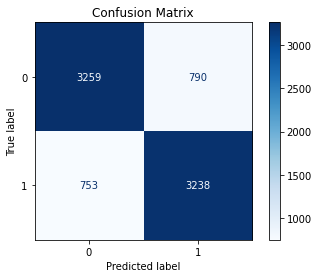

In [59]:
pred_test = gnb.predict(X_test)
print("Test AUC: {}".format(roc_auc_score(y_test, pred_test)))
print("Test Recall: {}".format(recall_score(y_test, pred_test)))
print("Test Precission: {}".format(precision_score(y_test, pred_test)))
print("Test Accuracy: {}".format(accuracy_score(y_test, pred_test)))
print("\n")
plot_confusion_matrix(gnb, X_test, y_test, values_format=".5g", cmap="Blues")
plt.title("Confusion Matrix");

# Kaggle Submission

In [60]:
# Kaggle test, not model test
df_test = pd.read_csv("test.csv.zip", compression='zip')

In [61]:
# Re-train with all data

gnb_kaggle = GaussianNB()
gnb_kaggle.fit(X, y)

kaggle_X_test = sc.transform(df_test.drop("ID_code", axis=1))

kaggle_pred = gnb_kaggle.predict(kaggle_X_test)

submission = pd.DataFrame()
submission["ID_code"] = df_test["ID_code"].copy()
submission["target"] = kaggle_pred

submission.to_csv("kaggle_santander_transactions_submission.csv", index=False)

# THIS RETURNS A 0.80469 PRIVATE SCORE ON KAGGLE (highest I ever had)

In [62]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f kaggle_santander_transactions_submission.csv -m "Submission"

100% 2.56M/2.56M [00:00<00:00, 8.53MB/s]
Successfully submitted to Santander Customer Transaction Prediction

# Results

Gaussian Naive Bayes was the best performing model of the 3 (Logistic Regression, Random Forest Classifier and Gaussian Naive Bayes), but also the fastest. RFC was the slowest one.

The main metric used during the modelling was the ROC-AUC. GNB also returned good results in other metrics such as Recall and Precission, where these are very important in an imbalanced dataset (which one is more importan will depend on specific cases, uses and policies).

After re-training the model with all the data and submitting the test data to Kaggle it returned a 80.47% score, which is the highest I ever achieved for this competition.

As next steps, a deeper look into the outliers would be a good idea. I tried to use a 3 times the Standard Deviation approach to identify outliers but it was deleting the whole dataset... Also, I didn't perform any data reduction since the models could handle all the dataset. However, experimenting with this would also be a good next step.